#### Imports

In [6]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly.plotly as py

import math

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn import metrics
import datetime as datetime
import graphviz

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid.axislines import Subplot

import time

In [2]:
df_main = pd.read_csv('Data.csv')

In [3]:
df_main.head()

,ID,Salary,DOJ,DOL,Original Designation,Designation,Domain,JobCity,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,Degree,Specialization,collegeGPA,CollegeCityID,CollegeCityTier,CollegeState,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
0,42418,435000.0,5/1/2010 0:00,6/1/2014 0:00,electrical engineer,electrical engineer,Engineering,Bhopal,f,10/23/1987 0:00,65.0,cbse,2005,54.0,cbse,402,1,B.Tech/B.E.,biomedical engineering,65.90,402,0,Madhya Pradesh,2010,405,425,405,0.0,0,0,0,0,0,0,0,0.9737,-0.2793,-1.2148,-0.8778,0.5024
1,214964,315000.0,8/1/2011 0:00,7/1/2012 0:00,senior software engineer,senior software engineer,Engineering,Mumbai,f,12/25/1988 0:00,88.4,cbse,2006,79.2,cbse,332,1,B.Tech/B.E.,biomedical engineering,69.54,332,0,Punjab,2011,525,705,524,0.0,0,0,0,0,0,0,0,0.9737,-0.1232,-1.0697,1.5899,0.9763
2,900218,420000.0,7/1/2010 0:00,8/1/2011 0:00,management trainee,trainee manager,Management,NCR,m,1/11/1988 0:00,82.0,cbse,2005,75.8,cbse,443,1,M.Tech./M.E.,other,82.50,443,0,Uttar Pradesh,2014,625,520,705,0.0,0,0,0,0,0,0,0,-1.8825,0.5454,-0.9122,-0.1076,-1.4356
3,220655,400000.0,6/1/2011 0:00,3/1/2013 0:00,team leader,technical lead,Management,Chandigarh,m,11/16/1989 0:00,88.2,cbse,2007,77.8,cbse,285,1,B.Tech/B.E.,chemical engineering,62.40,285,0,Punjab,2011,595,695,575,0.0,0,0,0,0,0,0,0,-1.0355,0.9688,-0.6343,-0.4078,0.0284
4,962376,700000.0,7/1/2014 0:00,NaN,product manager,product manager,Management,Jaipur,m,1/3/1992 0:00,87.4,cbse,2009,74.0,state board,436,1,M.Tech./M.E.,other,72.79,436,0,Uttarakhand,2014,625,450,655,0.0,0,0,0,0,0,0,0,-0.3027,-0.4536,-0.6048,-0.8682,0.0973


#### Data Cleansing

In [8]:
df = df_main.copy()
# Drop irrelevant columns
df.drop(['ID', 'DOJ', 'DOL','Original Designation','Designation', 'DomainScore'], axis=1, inplace=True)

# Trim all string inputs
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Encoding Gender as Binary (0 = Male, 1 = Female)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x.lower() == 'f' else 0)
from datetime import datetime
today = datetime.now()

# Covering DOB to Age
df['Age'] = df['DOB'].apply(lambda x: np.round((today - datetime.strptime(x, '%m/%d/%Y %H:%M')).days / 365),0)

In [400]:
cols = ['ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience', 'MechanicalEngg', 'ElectricalEngg', 'TelecomEngg', 'CivilEngg']
for col in cols:
    df[col] = df[col].apply(lambda x: np.nan if x == 0 else x/900)

df['SecScore'] = df[cols].mean(axis=1)
df['SecScore'] = df['SecScore'].apply(lambda x: -1 if math.isnan(x) else x)

for col in cols:
    df[col] = df[col].apply(lambda x: 0 if math.isnan(x) else 1)


In [401]:
# Rename columns
df = df.rename(columns={'conscientiousness': 'Conscientiousness',
                        'agreeableness': 'Agreeableness',
                        'extraversion': 'Extraversion',
                        'nueroticism': 'Nueroticism',
                        'openess_to_experience': 'OTE'})

# Create 1-hot features for categorical variables
df = pd.concat([df, pd.get_dummies(df['Degree'])], axis=1)
# df = pd.concat([df, pd.get_dummies(df['CollegeState'])], axis=1)

# Filter for top 20 cities based on the number of records. Some cities have only 1 record and this is done to limit the outliers
df = df[df.JobCity.isin(list(df.groupby(['JobCity']).size().nlargest(20).reset_index(drop=False)['JobCity']))]
# df = pd.concat([df, pd.get_dummies(df['JobCity'])], axis=1)

# Drop irrelevant columns
df.drop(columns=['JobCity', 'DOB', 'Degree', 'CollegeState', '10percentage', '10board', '12graduation', '12percentage', '12board', 'CollegeID', 'CollegeCityID', 'CollegeCityTier'], axis=1, inplace=True)

# Create EECS as a combined specialization
df['Specialization'] = df['Specialization'].apply(lambda x: 'Other Specialization' if x.lower() == 'other' else x)
df['Specialization'] = df['Specialization'].apply(lambda x: 'Electrical Engineering & Computer Science' if x in ['electronics engineering', 'electrical engineering', 'computer science'] else x)
df['Specialization'] = df['Specialization'].apply(lambda x: x.title())
df = pd.concat([df, pd.get_dummies(df['Specialization'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Domain'])], axis=1)

df['NumExp'] = df['GraduationYear'].apply(lambda x: datetime.now().year - x)

df.drop(columns=['Specialization', 'Domain', 'GraduationYear'], axis=1, inplace=True)

In [402]:
# Standardize test scores
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

df['English'] = standardize(np.asarray(df['English']))
df['Logical'] = standardize(np.asarray(df['Logical']))
df['Quant'] = standardize(np.asarray(df['Quant']))
df['collegeGPA'] = standardize(np.asarray(df['collegeGPA']))
df['Age'] = standardize(np.asarray(df['Age']))

In [403]:
df

,Salary,Gender,CollegeTier,collegeGPA,English,Logical,Quant,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,Conscientiousness,Agreeableness,Extraversion,Nueroticism,OTE,Age,SecScore,B.Tech/B.E.,M.Sc. (Tech.),M.Tech./M.E.,MCA,Biomedical Engineering,Chemical Engineering,Civil Engineering,Computer Application,Electrical Engineering & Computer Science,Information Technology,Mechanical Engineering,Other Specialization,Business,Education,Engineering,Finance,HR,Management,Marketing,Operations,QA,Research,Sales,Support,Tech,UX/UI Design,NumExp
0,435000.0,1,1,-0.778372,-0.921540,-0.866012,-0.875128,0,0,0,0,0,0,0,0.9737,-0.2793,-1.2148,-0.8778,0.5024,1.6869,-1.000000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,7
1,315000.0,1,1,-0.290703,0.228911,2.344029,0.101840,0,0,0,0,0,0,0,0.9737,-0.1232,-1.0697,1.5899,0.9763,1.12638,-1.000000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6
2,420000.0,0,1,1.445612,1.187620,0.223109,1.587817,0,0,0,0,0,0,0,-1.8825,0.5454,-0.9122,-0.1076,-1.4356,1.6869,-1.000000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3
3,400000.0,0,1,-1.247285,0.900008,2.229385,0.520541,0,0,0,0,0,0,0,-1.0355,0.9688,-0.6343,-0.4078,0.0284,0.565862,-1.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6
4,700000.0,0,1,0.144715,1.187620,-0.579402,1.177326,0,0,0,0,0,0,0,-0.3027,-0.4536,-0.6048,-0.8682,0.0973,-0.555176,-1.000000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3
6,720000.0,0,1,0.400607,0.420653,0.509720,0.643688,0,0,0,0,0,0,1,-1.1644,0.3789,0.3174,1.1601,-0.2859,-0.555176,0.555556,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4
7,600000.0,0,1,0.813250,2.194265,1.770807,2.203554,0,0,0,0,0,0,1,0.8463,0.8784,0.4711,-2.0092,-0.2859,-1.11569,0.431111,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4
8,315000.0,1,1,1.110675,1.331427,0.280431,0.274246,0,0,0,0,0,0,0,1.1336,1.0449,0.4711,-1.6289,0.8637,-1.11569,-1.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
9,300000.0,1,1,-0.805167,0.420653,1.197586,1.382572,0,0,0,0,0,0,1,0.2718,-0.4536,0.4711,-1.1218,0.0973,-0.555176,0.431111,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3
10,730000.0,0,1,1.887729,0.420653,0.280431,1.669915,0,0,0,0,0,0,0,-1.3447,-1.0593,0.6720,1.0024,-1.7093,0.565862,-1.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6


In [426]:
# Create salary buckets and drop records for salary less than 1L
def get_salary_bucket(x):
    if (x < 300000):
        return 0
    elif (x < 1000000):
        return 1
    else:
        return 2

df['Salary Bucket'] = df['Salary'].apply(get_salary_bucket)

In [453]:
# Use K-Means Clustering to find out the Salary Buckets
for k in range(2, 9):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(df['Salary'].reshape(-1, 1))
    labels = kmeans_model.labels_
    print('k = {}, Score = {}'.format(k, metrics.silhouette_score(df['Salary'].reshape(-1, 1), labels, metric='euclidean')))

C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



k = 2, Score = 0.8825400221378333
k = 3, Score = 0.5581951591397114
k = 4, Score = 0.6116402075328272
k = 5, Score = 0.6142089278217479
k = 6, Score = 0.605682242595321
k = 7, Score = 0.5993173140148096
k = 8, Score = 0.6176466206678367


In [477]:
# Using K = 4, since K = 2 would not make much sense
kmeans_model = KMeans(n_clusters=5, random_state=1).fit(df['Salary'].reshape(-1, 1))
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

df1 = pd.DataFrame(labels, columns=['Class'])
df1.groupby('Class').size()

C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Class
0    1539
1      23
2     361
3    1326
4       3
dtype: int64

In [427]:
# Get X and y to train the model
X = df.copy()
X = X[X.Salary >= 100000]
# X = X[X.Salary < 800000]
X = X[X.SecScore != -1]
y = X['Salary Bucket']
# y = X['Salary']

X.drop(columns=['Salary', 'Salary Bucket'], axis=1, inplace=True)

In [428]:
# Split the set into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.34, random_state=12345)

In [429]:
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X, y)

cross_val = cross_validate(clf, X, y, cv=10, return_train_score=True)
print('Avg Training Accuracy: {0:.2f}%'.format(cross_val['train_score'].mean() * 100))
print('Avg Test Accuracy: {0:.2f}%'.format(cross_val['test_score'].mean() * 100))

Avg Training Accuracy: 100.00%
Avg Test Accuracy: 55.70%


In [430]:
rf = RandomForestClassifier()
rf = rf.fit(X, y)

cross_val = cross_validate(rf, X, y, cv=25, return_train_score=True)
print('Avg Training Accuracy: {0:.2f}%'.format(cross_val['train_score'].mean() * 100))
print('Avg Test Accuracy: {0:.2f}%'.format(cross_val['test_score'].mean() * 100))

Avg Training Accuracy: 98.76%
Avg Test Accuracy: 66.33%


In [433]:
rf = RandomForestClassifier(max_depth=5, random_state=12345, n_estimators=50, min_samples_leaf=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [434]:
rf.score(X_test, y_test)

0.70554493307839383

In [435]:
rf = RandomForestClassifier(n_estimators=20)
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 5, 7, 10],
              "min_samples_split": [2, 3, 5, 7, 10],
              "min_samples_leaf": [1, 3, 5, 7, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

grid_search = GridSearchCV(rf, param_grid=param_grid)
start = time.time()
grid_search.fit(X_train, y_train)
print("GridSearchCV took {:.2f} seconds for {} candidate parameter settings.".format(time.time() - start_time, len(grid_search.cv_results_['params'])))

GridSearchCV took 5488.16 seconds for 1000 candidate parameter settings.


In [436]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

rf = grid_search.best_estimator_
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'bootstrap': False, 'criterion': 'gini', 'max_features': 3, 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 3}
0.708579881657


0.70841300191204593

C:\Users\Arnav\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

C:\Users\Arnav\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



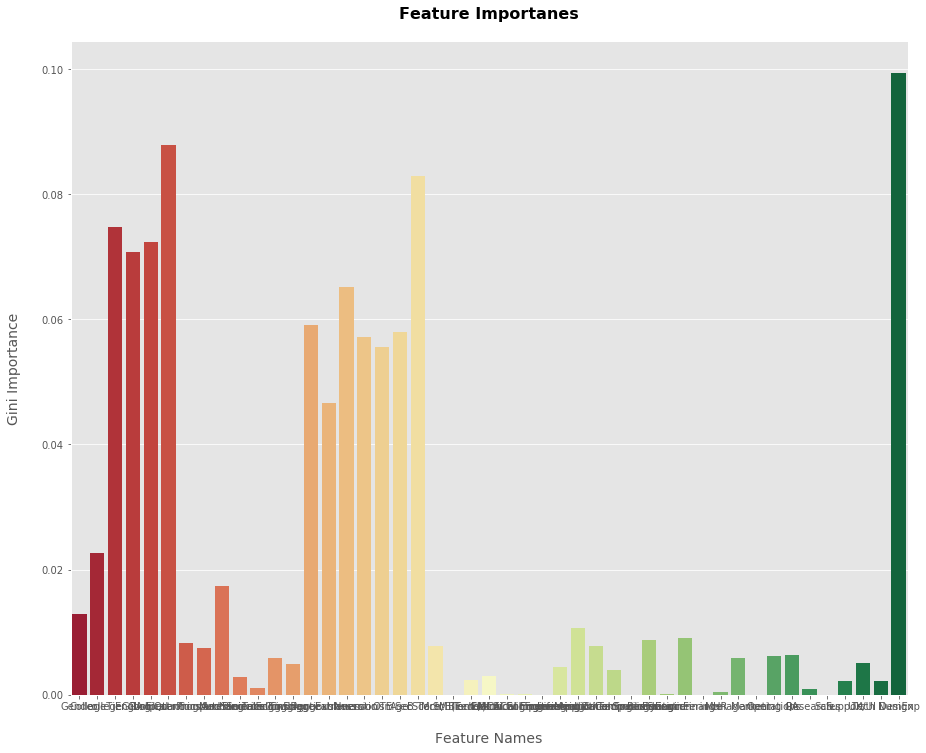

In [413]:
fi = rf.feature_importances_

plt.figure(figsize=(15, 12))
sns.barplot(X.columns, fi, palette='RdYlGn')
plt.title('Feature Importanes\n', fontsize=16, fontweight='bold')
plt.xlabel('\nFeature Names', fontsize=14)
plt.ylabel('Gini Importance\n', fontsize=14)
plt.axes().spines['top'].set_visible(False)
plt.axes().spines['right'].set_visible(False)

plt.show()

In [437]:
# Make a model for the different salary buckets (Bucket 0)
X = df.copy()
X = X[X['Salary Bucket'] == 0]
X = X[X.SecScore != -1]
X['Salary Bucket'] = X['Salary'].apply(lambda x: np.floor(x / 10000))
y = X['Salary Bucket']

# X.drop(columns=['Salary', 'Salary Bucket'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.34, random_state=12345)

In [438]:
rf = RandomForestClassifier()
rf = rf.fit(X, y)

cross_val = cross_validate(rf, X, y, cv=25, return_train_score=True)
print('Avg Training Accuracy: {0:.2f}%'.format(cross_val['train_score'].mean() * 100))
print('Avg Test Accuracy: {0:.2f}%'.format(cross_val['test_score'].mean() * 100))

C:\Users\Arnav\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=25.



Avg Training Accuracy: 99.87%
Avg Test Accuracy: 78.77%


In [439]:
rf = RandomForestClassifier(n_estimators=20)
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 5, 7, 10],
              "min_samples_split": [2, 3, 5, 7, 10],
              "min_samples_leaf": [1, 3, 5, 7, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

grid_search = GridSearchCV(rf, param_grid=param_grid)
start = time.time()
grid_search.fit(X_train, y_train)
print("GridSearchCV took {:.2f} seconds for {} candidate parameter settings.".format(time.time() - start_time, len(grid_search.cv_results_['params'])))

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

C:\Users\Arnav\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.



GridSearchCV took 5786.14 seconds for 1000 candidate parameter settings.
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'bootstrap': False, 'criterion': 'gini', 'max_features': 10, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.899891186072


In [442]:
rf = grid_search.best_estimator_
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.95358649789029537

In [ ]:
fi = rf.feature_importances_

plt.figure(figsize=(15, 12))
sns.barplot(X.columns, fi, palette='RdYlGn')
plt.title('Feature Importanes\n', fontsize=16, fontweight='bold')
plt.xlabel('\nFeature Names', fontsize=14)
plt.ylabel('Gini Importance\n', fontsize=14)
plt.axes().spines['top'].set_visible(False)
plt.axes().spines['right'].set_visible(False)

plt.show()

In [418]:
linear_reg = LinearRegression()
linear_reg = linear_reg.fit(X_train, y_train)

In [419]:
y_pred = linear_reg.predict(X_train)
rmse_train = compute_rmse(y_pred, y_train)
print('Train RMSE = {}'.format(rmse_train))

Train RMSE = 0.0


In [420]:
y_pred = linear_reg.predict(X_test)
rmse_test = compute_rmse(y_pred, y_test)
print('Test RMSE = {}'.format(rmse_test))

Test RMSE = 0.0


In [382]:
def compute_rmse(predictions, yvalues):
    sub_sq = np.power(np.subtract(predictions, yvalues), 2)
    se = np.sum(sub_sq)
    mse = se/len(predictions)
    rmse = np.round(np.sqrt(mse), 2)
    return rmse

y_pred = (alpha + np.dot(X_train, beta))
rmse_train = compute_rmse(y_pred, y_train)

y_pred = (alpha + np.dot(X_test, beta))
rmse_test = compute_rmse(y_pred, y_test)

print("Time taken: {:.2f} seconds".format(time.time() - start_time))
print('Alpha = {}'.format(alpha))
print('Beta = {}'.format(beta))
print('\nTest RMSE = {}'.format(rmse_test))
print('Train RMSE = {}'.format(rmse_train))

C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Arnav\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in double_scalars
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [377]:
y

9       3.00
20      1.80
23      1.80
50      3.00
60      2.70
65      3.00
68      3.20
75      2.25
76      3.10
77      1.90
87      3.10
95      2.40
98      2.40
99      3.75
119     1.80
126     3.25
135     4.50
159     2.80
160     1.20
161     1.90
162     1.80
163     1.20
164     3.50
165     2.30
166     1.00
169     2.00
170     1.70
172     2.20
178     2.00
180     2.65
        ... 
3947    4.40
3949    3.00
3950    3.00
3952    3.00
3954    4.00
3955    1.60
3956    3.25
3957    2.40
3958    3.30
3959    2.00
3960    3.30
3961    2.80
3963    3.25
3966    3.05
3967    4.50
3968    1.80
3969    4.50
3970    2.40
3972    1.45
3973    2.25
3974    2.20
3975    3.50
3977    2.00
3978    3.60
3979    3.20
3980    2.15
3981    3.60
3982    3.50
3984    2.50
3987    3.20
Name: Salary, Length: 2772, dtype: float64